# MLP
Convert CNN_264 to an MLP.

More epochs.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-27 15:00:43.080332


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

2023-03-27 15:00:43.119083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU device not found
/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/


2023-03-27 15:00:52.437150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=50 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.10.0
sklearn 1.1.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(8, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-27 15:00:54.999228
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16512     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,041
Trainable params: 17,041
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-27 15:00:55.324446
Load RCI from /Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-27 15:01:08.698292

Training # 1 1
2023-03-27 15:01:08.698344
2023-03-27 15:01:08.698370
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-27 15:01:08.752627


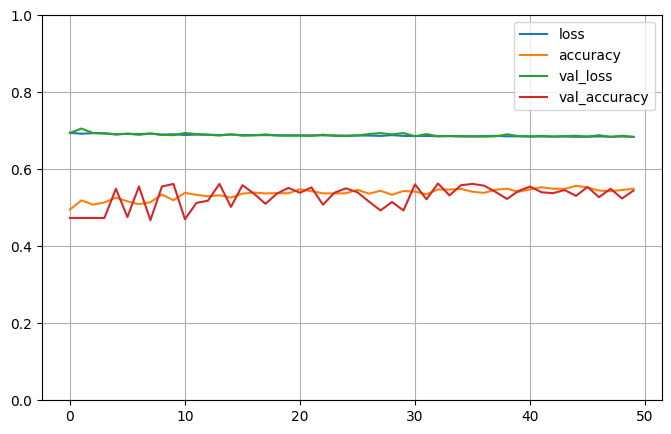


2023-03-27 15:01:30.410018

Testing # 1 1
2023-03-27 15:01:30.410065
2023-03-27 15:01:30.410081
PREDICT
2023-03-27 15:01:30.415606
Test 1:0 458:412 52.64%
Predict 1:0 556:314 63.91%
Test sizes (870, 257) (870,)
Range of scores: 0.30213958 to 0.5690161
Score threshold 0.5
Confusion matrix
 [[165 247]
 [149 309]]
Normalized matrix
 [[0.18965517 0.28390805]
 [0.17126437 0.35517241]]


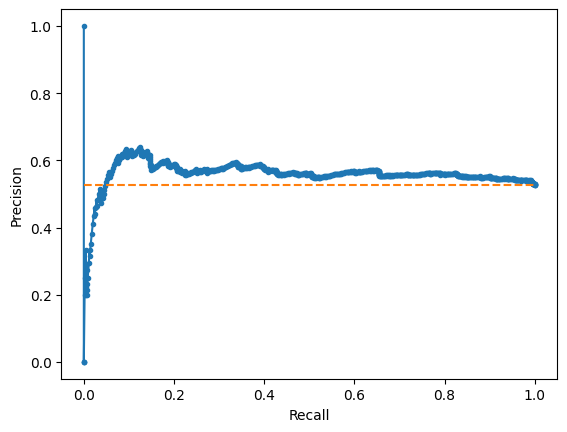

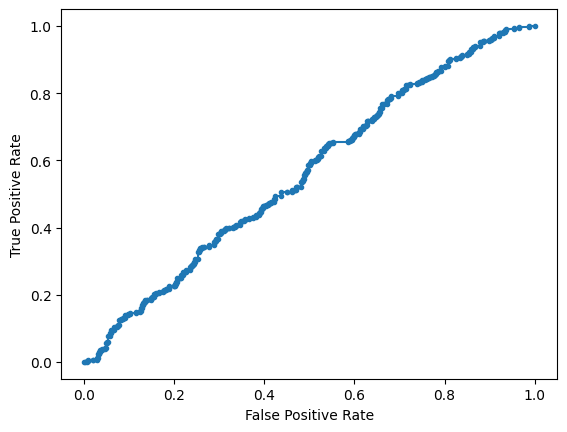

Accuracy: 54.48% Precision: 55.58% Recall: 67.47%
F1: 60.95% MCC: 0.0781
AUPRC: 55.90% AUROC: 56.05%
 accuracy [54.48275862068965]
 precision [55.57553956834532]
 recall [67.46724890829694]
 F1 [60.946745562130175]
 MCC [0.0781364928748186]
 AUPRC [55.89915563140223]
 AUROC [56.049412812142286]
2023-03-27 15:01:30.970847

Training # 1 2
2023-03-27 15:01:30.970929
2023-03-27 15:01:30.970965
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-27 15:01:31.043833


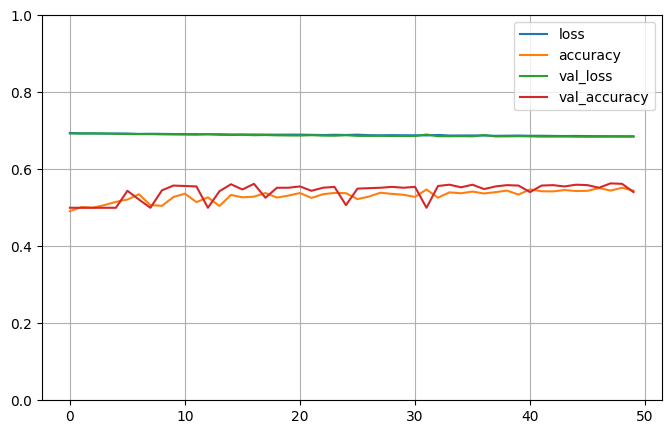


2023-03-27 15:01:49.375157

Testing # 1 2
2023-03-27 15:01:49.375198
2023-03-27 15:01:49.375231
PREDICT
2023-03-27 15:01:49.381033
Test 1:0 442:442 50.00%
Predict 1:0 426:458 48.19%
Test sizes (884, 257) (884,)
Range of scores: 0.3186511 to 0.53618306
Score threshold 0.5
Confusion matrix
 [[247 195]
 [211 231]]
Normalized matrix
 [[0.27941176 0.22058824]
 [0.23868778 0.26131222]]


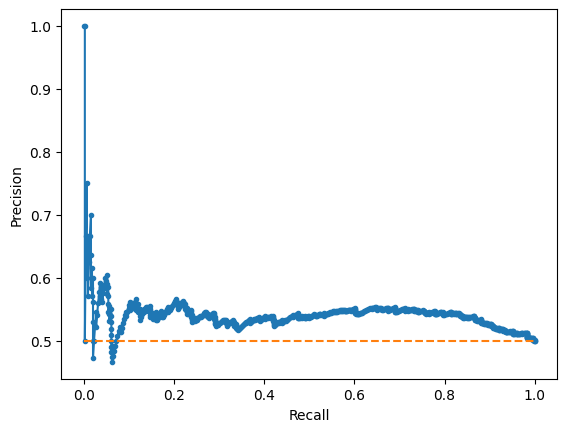

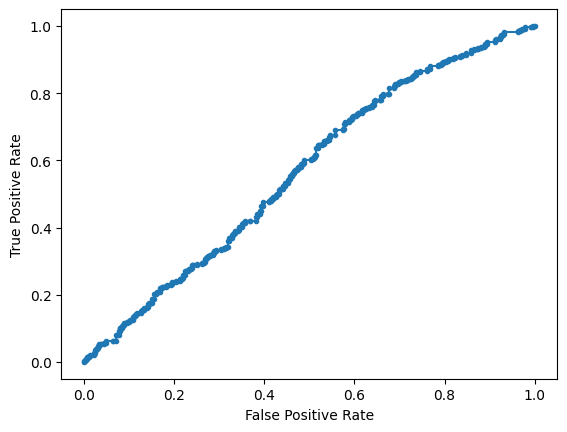

Accuracy: 54.07% Precision: 54.23% Recall: 52.26%
F1: 53.23% MCC: 0.0815
AUPRC: 54.14% AUROC: 56.74%
 accuracy [54.07239819004525]
 precision [54.22535211267606]
 recall [52.26244343891403]
 F1 [53.22580645161291]
 MCC [0.08150137996965445]
 AUPRC [54.14221064017472]
 AUROC [56.739215003787805]
2023-03-27 15:01:49.898313

Training # 1 3
2023-03-27 15:01:49.898384
2023-03-27 15:01:49.898415
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-27 15:01:49.970854


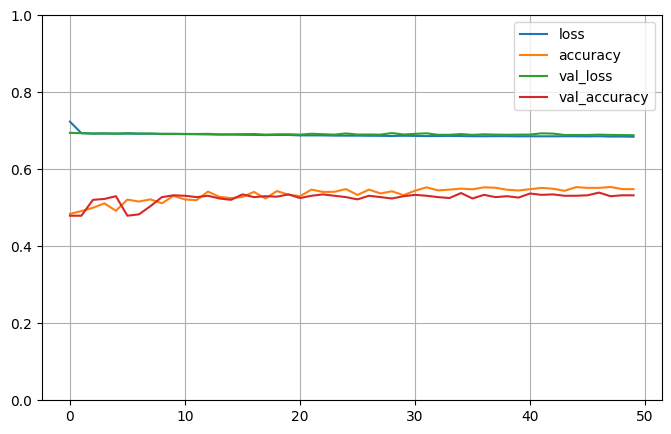


2023-03-27 15:02:05.534401

Testing # 1 3
2023-03-27 15:02:05.534446
2023-03-27 15:02:05.534460
PREDICT
2023-03-27 15:02:05.541750
Test 1:0 442:407 52.06%
Predict 1:0 667:182 78.56%
Test sizes (849, 257) (849,)
Range of scores: 0.31183058 to 0.5694773
Score threshold 0.5
Confusion matrix
 [[ 96 311]
 [ 86 356]]
Normalized matrix
 [[0.1130742  0.36631331]
 [0.10129564 0.41931684]]


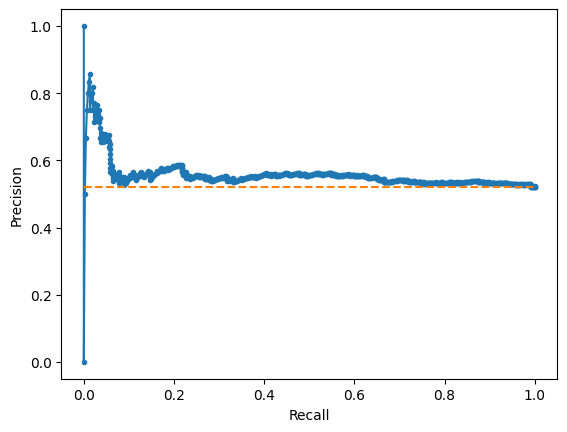

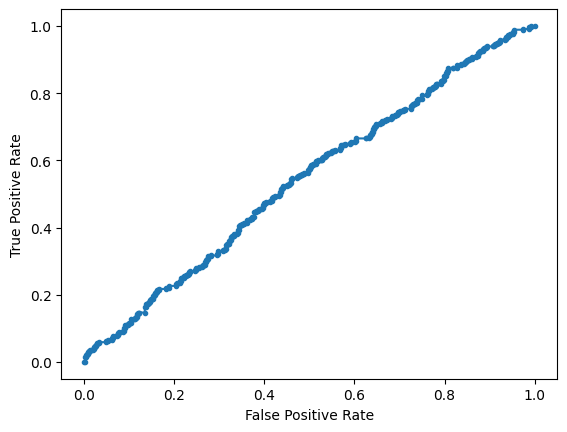

Accuracy: 53.24% Precision: 53.37% Recall: 80.54%
F1: 64.20% MCC: 0.0503
AUPRC: 55.62% AUROC: 54.24%
 accuracy [53.23910482921084]
 precision [53.373313343328334]
 recall [80.54298642533936]
 F1 [64.2019837691614]
 MCC [0.05027844801689018]
 AUPRC [55.62134069635982]
 AUROC [54.24444395032631]
2023-03-27 15:02:06.142132

Training # 1 4
2023-03-27 15:02:06.142189
2023-03-27 15:02:06.142212
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-27 15:02:06.208240


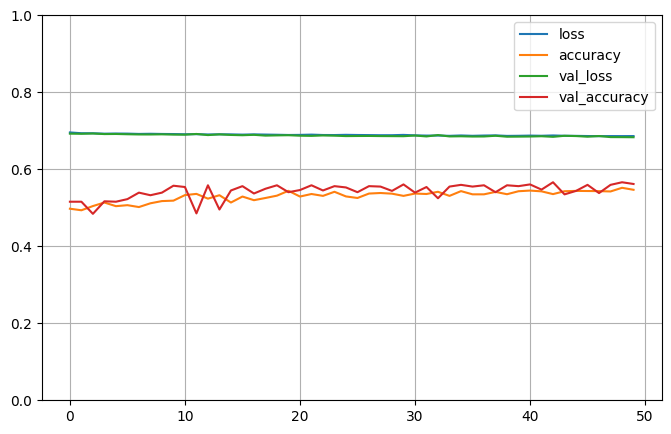


2023-03-27 15:02:23.405790

Testing # 1 4
2023-03-27 15:02:23.405840
2023-03-27 15:02:23.405854
PREDICT
2023-03-27 15:02:23.411868
Test 1:0 459:431 51.57%
Predict 1:0 627:263 70.45%
Test sizes (890, 257) (890,)
Range of scores: 0.33896002 to 0.5778174
Score threshold 0.5
Confusion matrix
 [[152 279]
 [111 348]]
Normalized matrix
 [[0.17078652 0.31348315]
 [0.1247191  0.39101124]]


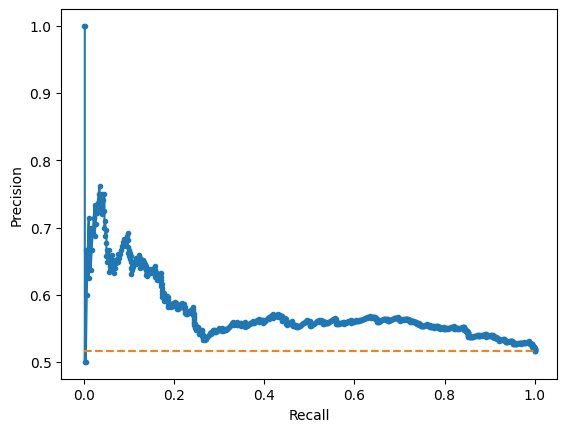

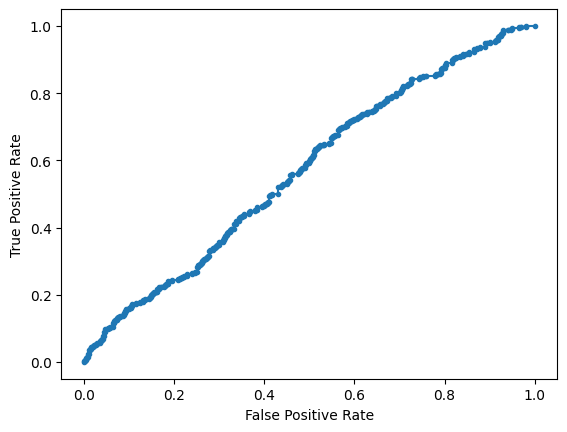

Accuracy: 56.18% Precision: 55.50% Recall: 75.82%
F1: 64.09% MCC: 0.1214
AUPRC: 57.42% AUROC: 57.05%
 accuracy [56.17977528089888]
 precision [55.50239234449761]
 recall [75.81699346405229]
 F1 [64.08839779005525]
 MCC [0.12140109224286848]
 AUPRC [57.41596003949652]
 AUROC [57.04522592744239]
2023-03-27 15:02:23.906086

Training # 1 5
2023-03-27 15:02:23.906160
2023-03-27 15:02:23.906192
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-27 15:02:23.965143


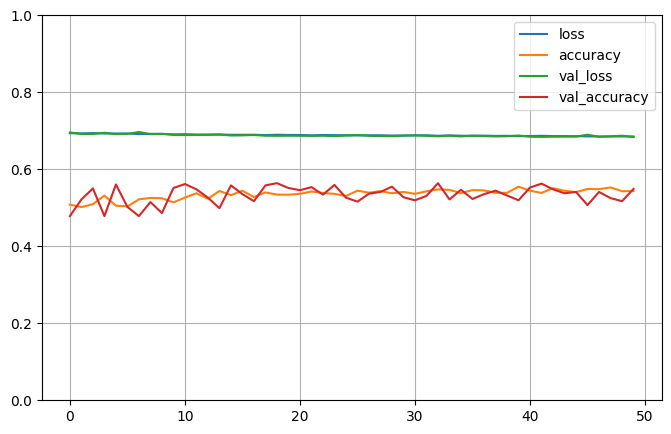


2023-03-27 15:02:40.140701

Testing # 1 5
2023-03-27 15:02:40.140738
2023-03-27 15:02:40.140752
PREDICT
2023-03-27 15:02:40.145872
Test 1:0 457:419 52.17%
Predict 1:0 560:316 63.93%
Test sizes (876, 257) (876,)
Range of scores: 0.3153815 to 0.5636234
Score threshold 0.5
Confusion matrix
 [[170 249]
 [146 311]]
Normalized matrix
 [[0.19406393 0.28424658]
 [0.16666667 0.35502283]]


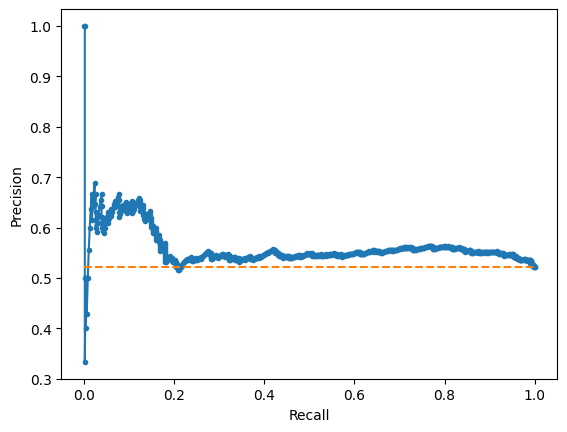

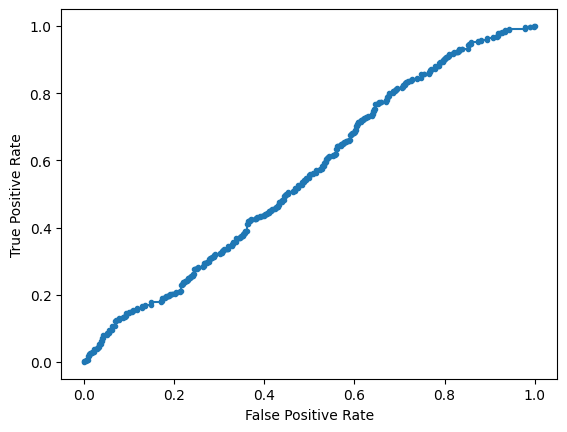

Accuracy: 54.91% Precision: 55.54% Recall: 68.05%
F1: 61.16% MCC: 0.0897
AUPRC: 56.02% AUROC: 55.49%
 accuracy [54.90867579908676]
 precision [55.53571428571429]
 recall [68.05251641137856]
 F1 [61.16027531956737]
 MCC [0.08972267389949808]
 AUPRC [56.017274167421796]
 AUROC [55.486910065123276]
2023-03-27 15:02:40.752342

Training # 2 1
2023-03-27 15:02:40.752399
2023-03-27 15:02:40.752423
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-27 15:02:40.830026


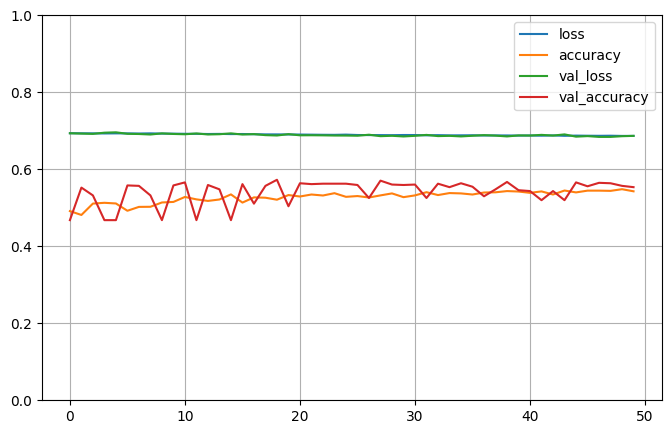


2023-03-27 15:02:59.881331

Testing # 2 1
2023-03-27 15:02:59.881367
2023-03-27 15:02:59.881382
PREDICT
2023-03-27 15:02:59.886300
Test 1:0 472:415 53.21%
Predict 1:0 496:391 55.92%
Test sizes (887, 257) (887,)
Range of scores: 0.31544495 to 0.54606634
Score threshold 0.5
Confusion matrix
 [[205 210]
 [186 286]]
Normalized matrix
 [[0.23111612 0.2367531 ]
 [0.2096956  0.32243517]]


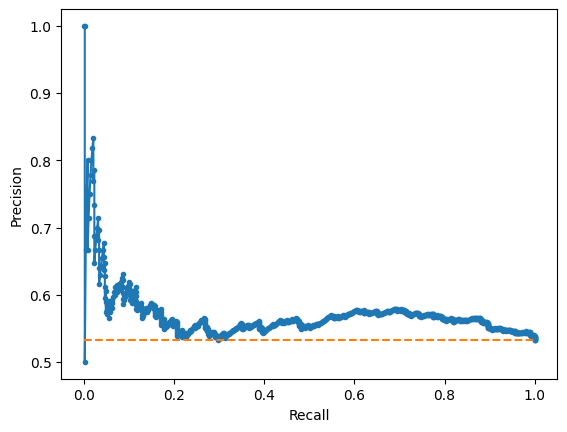

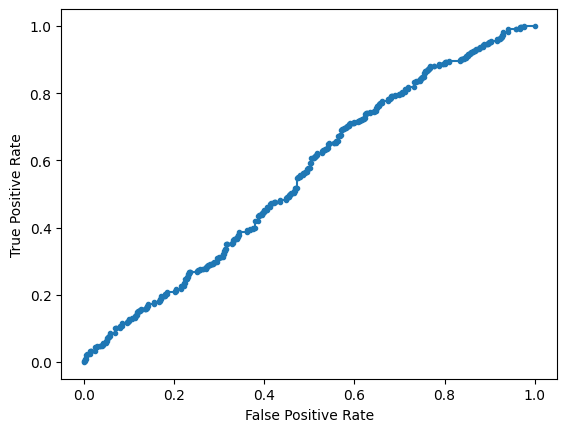

Accuracy: 55.36% Precision: 57.66% Recall: 60.59%
F1: 59.09% MCC: 0.1004
AUPRC: 57.00% AUROC: 55.42%
 accuracy [55.35512965050733]
 precision [57.66129032258065]
 recall [60.59322033898306]
 F1 [59.09090909090911]
 MCC [0.10040759412666671]
 AUPRC [56.998689935761625]
 AUROC [55.419134163773734]
2023-03-27 15:03:00.405876

Training # 2 2
2023-03-27 15:03:00.405941
2023-03-27 15:03:00.405967
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-27 15:03:00.467036


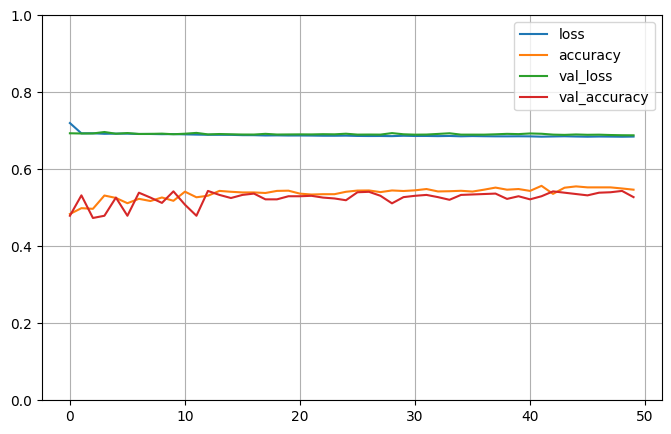


2023-03-27 15:03:14.958567

Testing # 2 2
2023-03-27 15:03:14.958612
2023-03-27 15:03:14.958626
PREDICT
2023-03-27 15:03:14.963664
Test 1:0 452:416 52.07%
Predict 1:0 642:226 73.96%
Test sizes (868, 257) (868,)
Range of scores: 0.29178694 to 0.5739777
Score threshold 0.5
Confusion matrix
 [[116 300]
 [110 342]]
Normalized matrix
 [[0.13364055 0.34562212]
 [0.12672811 0.39400922]]


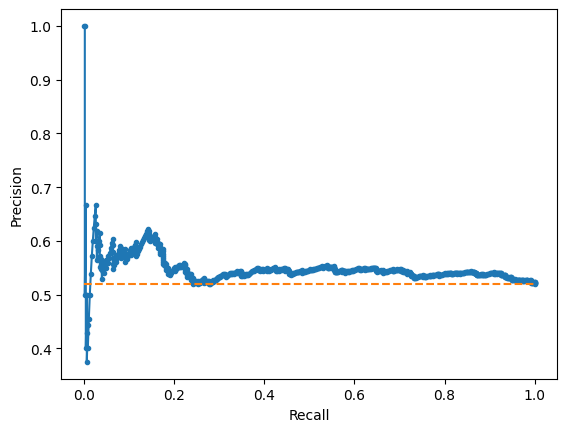

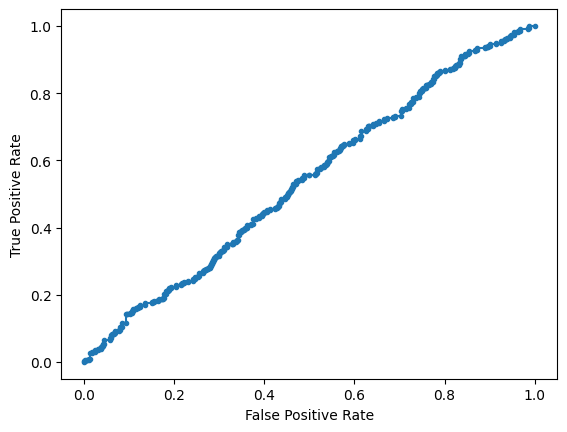

Accuracy: 52.76% Precision: 53.27% Recall: 75.66%
F1: 62.52% MCC: 0.0404
AUPRC: 54.77% AUROC: 53.89%
 accuracy [52.764976958525345]
 precision [53.271028037383175]
 recall [75.66371681415929]
 F1 [62.52285191956123]
 MCC [0.04039414511193496]
 AUPRC [54.772584847091906]
 AUROC [53.8876361470388]
2023-03-27 15:03:15.458844

Training # 2 3
2023-03-27 15:03:15.458911
2023-03-27 15:03:15.458939
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-27 15:03:15.516809


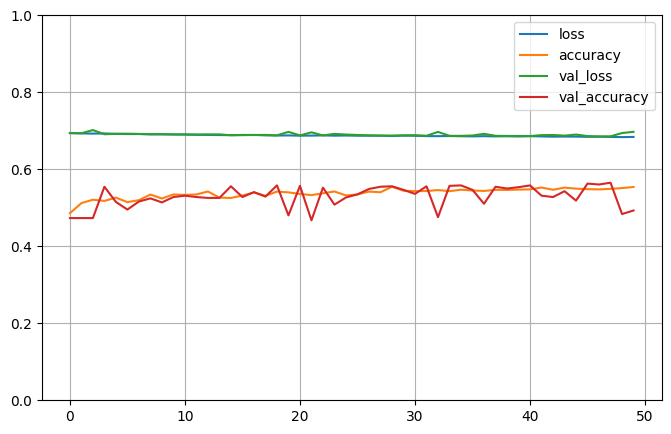


2023-03-27 15:03:30.126506

Testing # 2 3
2023-03-27 15:03:30.126552
2023-03-27 15:03:30.126567
PREDICT
2023-03-27 15:03:30.131638
Test 1:0 453:407 52.67%
Predict 1:0 81:779  9.42%
Test sizes (860, 257) (860,)
Range of scores: 0.25464287 to 0.51521647
Score threshold 0.5
Confusion matrix
 [[375  32]
 [404  49]]
Normalized matrix
 [[0.43604651 0.0372093 ]
 [0.46976744 0.05697674]]


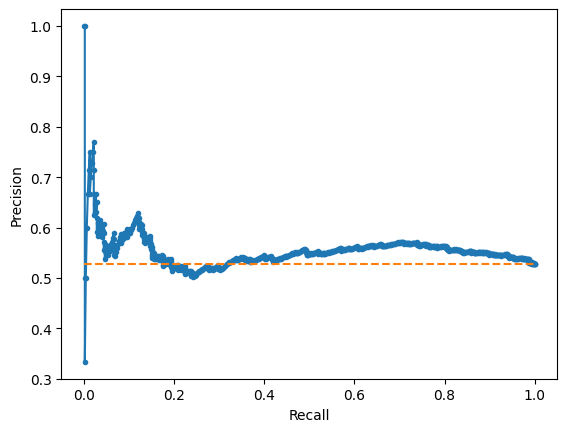

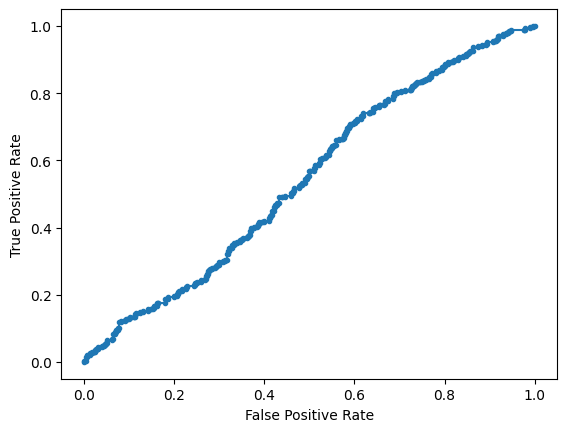

Accuracy: 49.30% Precision: 60.49% Recall: 10.82%
F1: 18.35% MCC: 0.0505
AUPRC: 55.41% AUROC: 54.49%
 accuracy [49.30232558139535]
 precision [60.49382716049383]
 recall [10.816777041942604]
 F1 [18.352059925093634]
 MCC [0.05050098295924581]
 AUPRC [55.41030621962315]
 AUROC [54.48579223413661]
2023-03-27 15:03:30.627084

Training # 2 4
2023-03-27 15:03:30.627147
2023-03-27 15:03:30.627172
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-27 15:03:30.694948


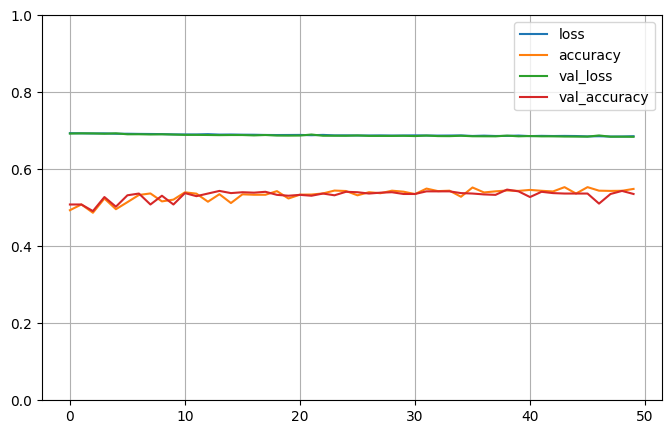


2023-03-27 15:03:47.449698

Testing # 2 4
2023-03-27 15:03:47.449736
2023-03-27 15:03:47.449752
PREDICT
2023-03-27 15:03:47.455313
Test 1:0 432:447 49.15%
Predict 1:0 476:403 54.15%
Test sizes (879, 257) (879,)
Range of scores: 0.30965674 to 0.54715836
Score threshold 0.5
Confusion matrix
 [[221 226]
 [182 250]]
Normalized matrix
 [[0.25142207 0.25711035]
 [0.20705347 0.28441411]]


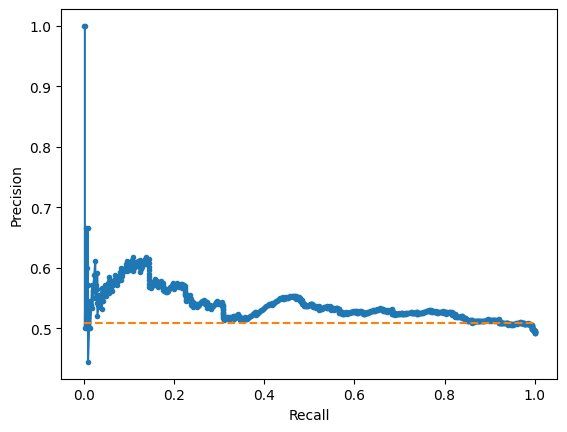

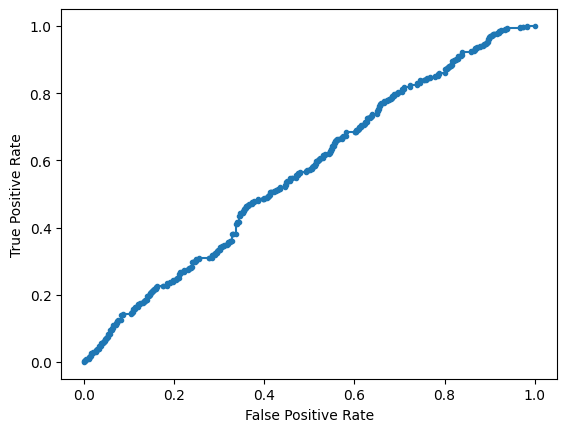

Accuracy: 53.58% Precision: 52.52% Recall: 57.87%
F1: 55.07% MCC: 0.0734
AUPRC: 53.93% AUROC: 56.48%
 accuracy [53.58361774744027]
 precision [52.52100840336135]
 recall [57.870370370370374]
 F1 [55.06607929515419]
 MCC [0.07335361865238829]
 AUPRC [53.92781508959978]
 AUROC [56.482517192808025]
2023-03-27 15:03:48.135922

Training # 2 5
2023-03-27 15:03:48.136255
2023-03-27 15:03:48.136286
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-27 15:03:48.301024


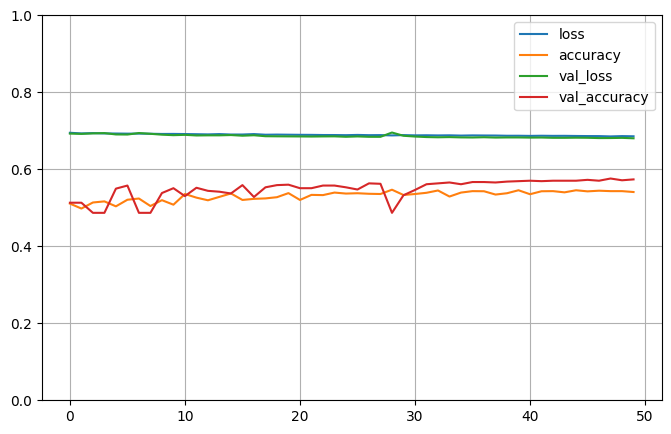


2023-03-27 15:04:08.295728

Testing # 2 5
2023-03-27 15:04:08.295799
2023-03-27 15:04:08.295838
PREDICT
2023-03-27 15:04:08.300577
Test 1:0 449:426 51.31%
Predict 1:0 588:287 67.20%
Test sizes (875, 257) (875,)
Range of scores: 0.33295393 to 0.56803036
Score threshold 0.5
Confusion matrix
 [[170 256]
 [117 332]]
Normalized matrix
 [[0.19428571 0.29257143]
 [0.13371429 0.37942857]]


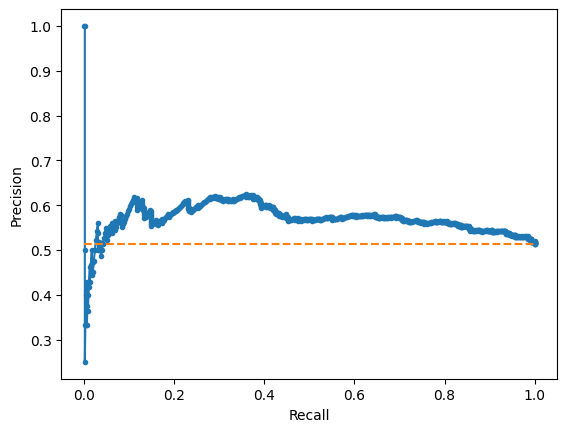

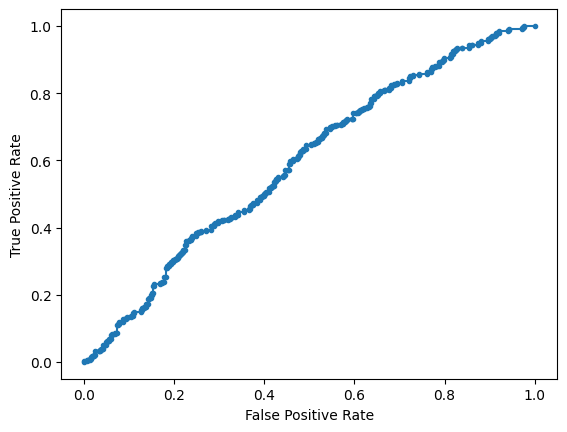

Accuracy: 57.37% Precision: 56.46% Recall: 73.94%
F1: 64.03% MCC: 0.1474
AUPRC: 56.98% AUROC: 59.24%
 accuracy [57.371428571428574]
 precision [56.4625850340136]
 recall [73.94209354120267]
 F1 [64.03085824493732]
 MCC [0.14743194203631665]
 AUPRC [56.97943631242859]
 AUROC [59.238056400765394]
2023-03-27 15:04:08.872973


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 54.13% std 2.19
 precision mean 55.46% std 2.37
 recall mean 62.30% std 20.17
 F1 mean 56.27% std 13.85
 MCC mean 0.08% std 0.03
 AUPRC mean 55.72% std 1.20
 AUROC mean 55.91% std 1.59
 accuracy [[54.48275862068965], [54.07239819004525], [53.23910482921084], [56.17977528089888], [54.90867579908676], [55.35512965050733], [52.764976958525345], [49.30232558139535], [53.58361774744027], [57.371428571428574]]
 precision [[55.57553956834532], [54.22535211267606], [53.373313343328334], [55.50239234449761], [55.53571428571429], [57.66129032258065], [53.271028037383175], [60.49382716049383], [52.52100840336135], [56.4625850340136]]
 recall [[67.46724890829694], [52.26244343891403], [80.54298642533936], [75.81699346405229], [68.05251641137856], [60.59322033898306], [75.66371681415929], [10.816777041942604], [57.870370370370374], [73.94209354120267]]
 F1 [[60.946745562130175], [53.22580645161291], [64.2019837691614], [64.08839779005525], [61.16027531956737], [59.09090909090911], [6